# Obtención y merjoramiento de la imagen

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import signal
import math
import os
import pandas as pd
import SimpleITK as sitk
import cv2

In [82]:
#from google.colab import drive
#drive.mount('/content/drive')


In [83]:

# aca pongan el path a su carpeta de imagenes del drive
image_dir = 'C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP imagenes/Imagenes/IMAGENES-20241006T160536Z-001/IMAGENES/'

# me armo una lista
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# creo un dataframe con las rutas de las imagenes
image_paths = pd.DataFrame({'ImagePath': [os.path.join(image_dir, f) for f in image_files]})

print(image_paths)

                                             ImagePath
0    C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP ima...
1    C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP ima...
2    C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP ima...
3    C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP ima...
4    C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP ima...
..                                                 ...
118  C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP ima...
119  C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP ima...
120  C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP ima...
121  C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP ima...
122  C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP ima...

[123 rows x 1 columns]


In [84]:
# creo un vector vacio para guardar las imagenes
images = []

# en cada valor guardo una imagen
for path in image_paths['ImagePath']:
    # leo en grices
    img = cv2.imread(path, 0)
    images.append(img)

# cantidad de imagenes cargadas
print(f"Cantidad total de imagenes: {len(images)}")

Cantidad total de imagenes: 123


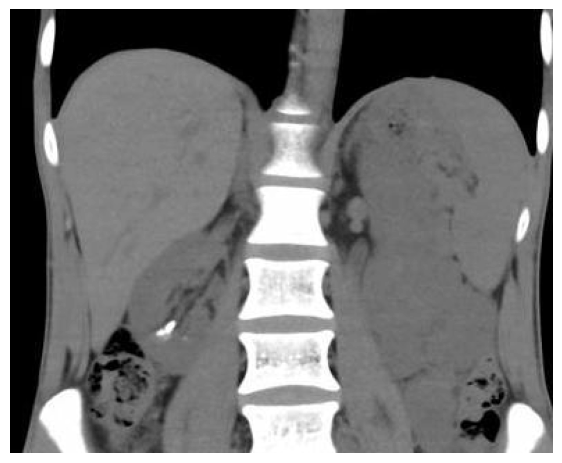

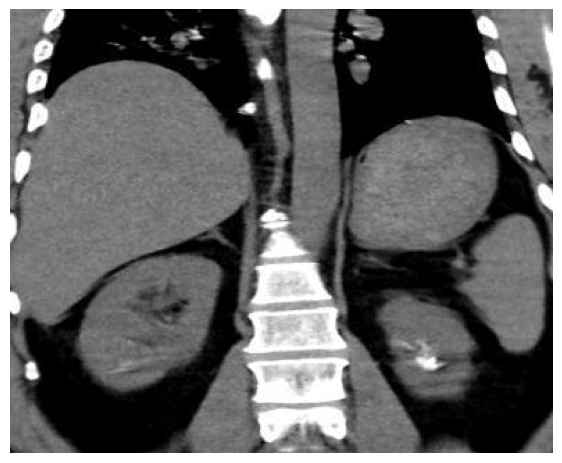

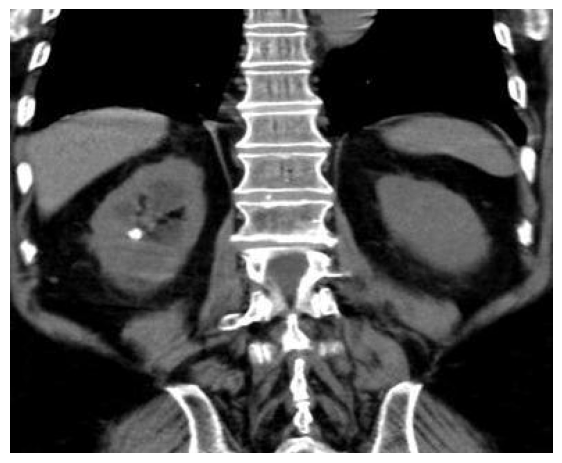

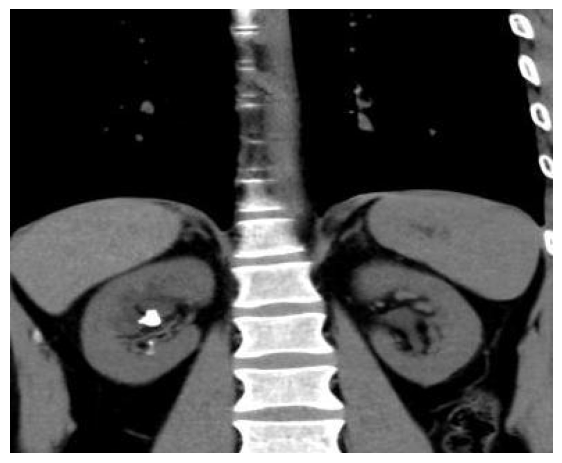

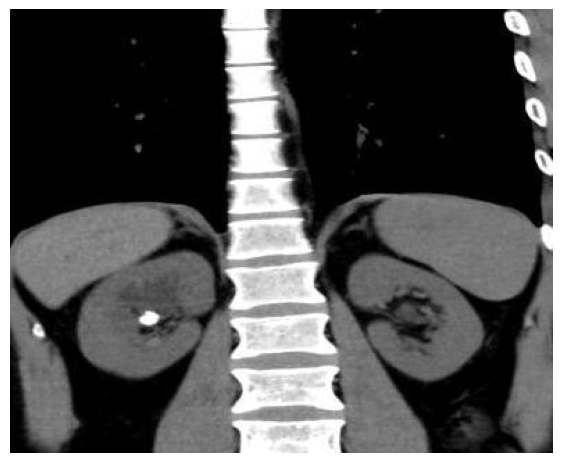

In [85]:
for i in range(0, 5):
    plt.figure(figsize=(7,7))
    plt.imshow(images[i], cmap="gray",vmin=0, vmax=255)
    plt.axis(False)
    plt.show()

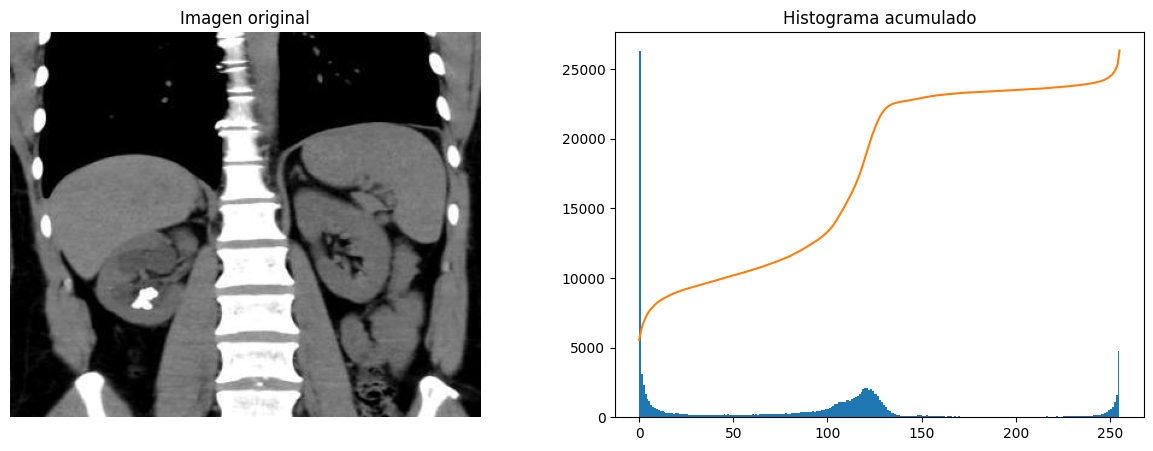

In [86]:
#Generamos histograma

hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()#acumulado
cdf_normalized = cdf *hist.max() / cdf.max()#lo normalizo

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(img,cmap="gray")
ax[0].axis(False)
ax[0].set_title("Imagen original")

ax[1].hist(np.ravel(img), bins=256, range=(0,255))
ax[1].plot(cdf_normalized)
ax[1].set_title("Histograma acumulado")
plt.show()


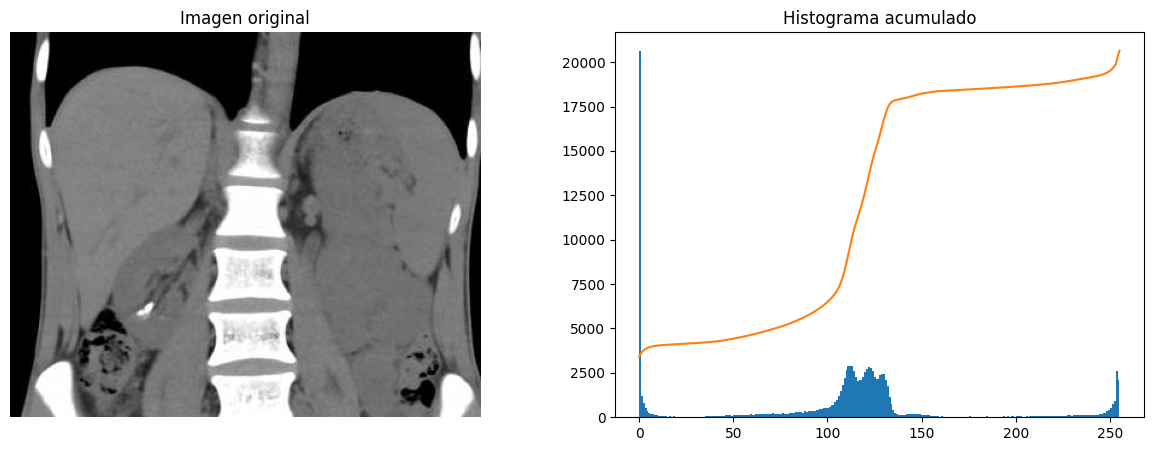

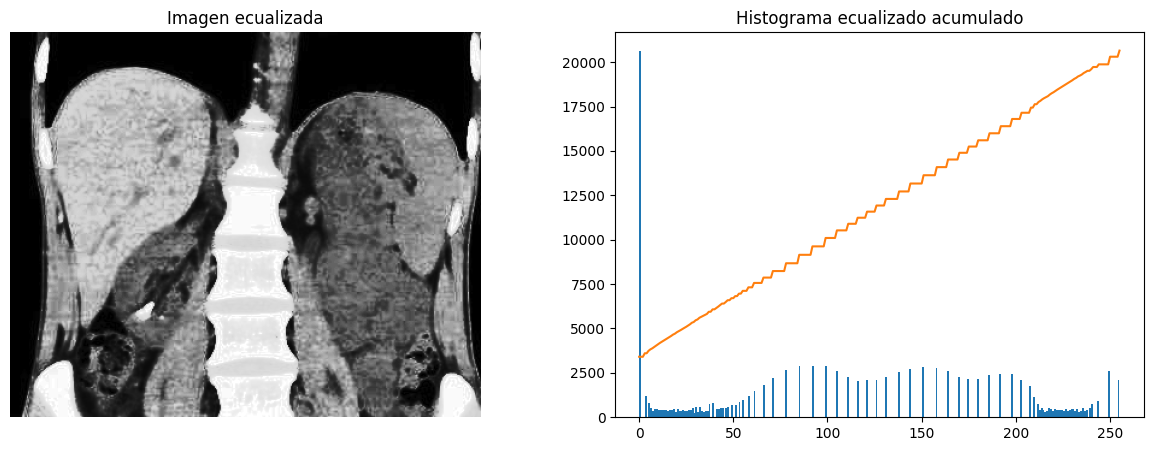

In [87]:
#Ecualizamos
img = images[0]
img_ec = cv2.equalizeHist(img)
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()#acumulado
cdf_normalized = cdf *hist.max() / cdf.max()#lo normalizo
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(img,cmap="gray")
ax[0].axis(False)
ax[0].set_title("Imagen original")

ax[1].hist(np.ravel(img), bins=256, range=(0,255))
ax[1].plot(cdf_normalized)
ax[1].set_title("Histograma acumulado")
plt.show()

hist,bins = np.histogram(img_ec.flatten(),256,[0,256])
cdf = hist.cumsum()#acumulado
cdf_normalized = cdf *hist.max() / cdf.max()#lo normalizo
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(img_ec,vmin=0, vmax=255,cmap='gray')
ax[0].set_title('Imagen ecualizada')
ax[0].axis(False)
ax[1].hist(np.ravel(img_ec), bins=256, range=(0,255))
ax[1].plot(cdf_normalized)
ax[1].set_title("Histograma ecualizado acumulado")
plt.show()

## Binarizacion

Para encontrar el calculo y poder segmentarlo, primeramente hay que **binarizar la imagen**. Para ello, conviene aplicar alguno de los metodos de umbralizado, como Otsu. Sin embargo, este último actua mejor sobre histogramas bimodales, por lo que la ecualización de la imagen no es útil en este caso.

105.0


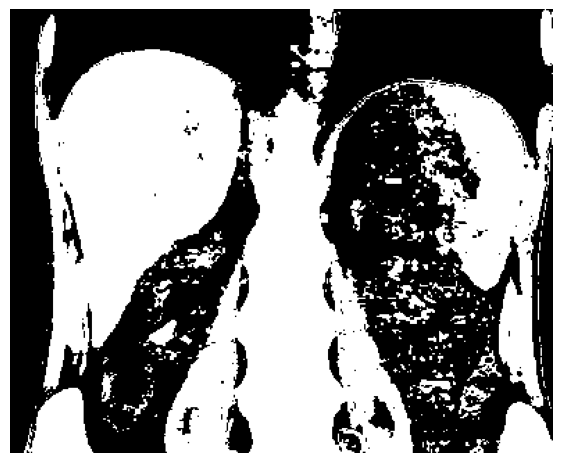

In [88]:
umbral, img_otsu = cv2.threshold(img_ec, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(umbral)
plt.figure(figsize=(7,7))
plt.imshow(img_otsu, cmap="gray",vmin=0, vmax=255)
plt.axis(False)
plt.show()

Vemos que por *Otsu* el resultado no es óptimo, dado que el histograma no es bimodal y hay presencia de grices cercanos a la región de interés. Por ende, no conviene realizar la binarización por este método. Lo ideal para sacar las regiones de gris cercanas al cálculo renal es clusterizarlas y binarizar luego.

In [89]:
def kmeans(imagen,k, iteraciones,epsilon):
  copia=imagen.copy()
  pixel_vals = copia.reshape((-1))#se pasa la dimensión de la imagen a no--> NO IMPORTA LA DISTRIBUCIÓN ESPACIAL
  pixel_vals = np.float32(pixel_vals)#El algoritmos nos pide floats de 32 bits
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, iteraciones, epsilon) #se para el algoritmo cuando se haya cumplido el epsilon o cuando se hayan acabado las iteraciones,cada attemp itera n veces, epsilon (precision)

  flags = cv2.KMEANS_RANDOM_CENTERS #situa los centroides inicales

  compactness, labels, centers = cv2.kmeans(pixel_vals, 3, None, criteria, 10, flags)

  center = np.uint8(centers)

  img_1_kmeans = center[labels.flatten()] #Asigna a cada píxel el valor del centro del cluster al que pertenece
  img_1_kmeans = img_1_kmeans.reshape((copia.shape))
  centers=centers.flatten()
  return img_1_kmeans, centers



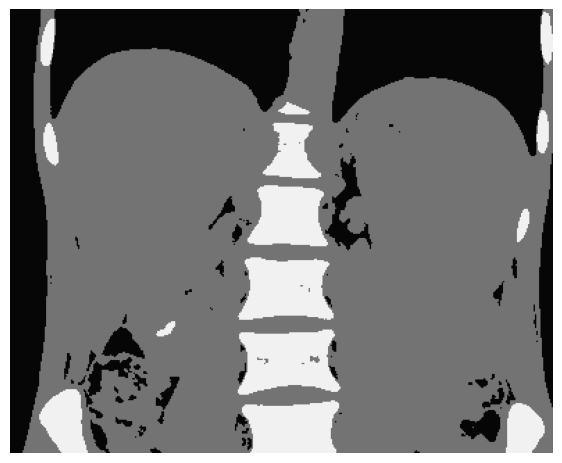

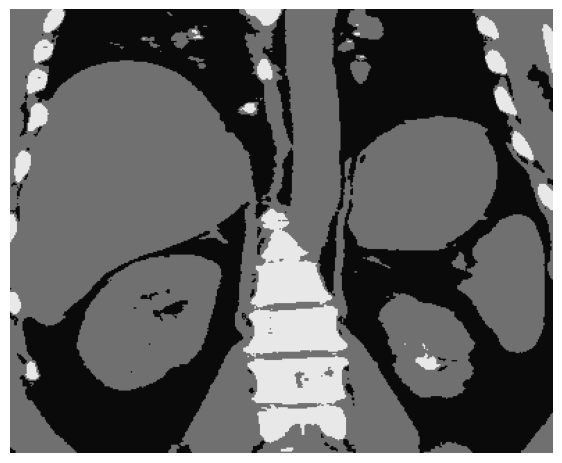

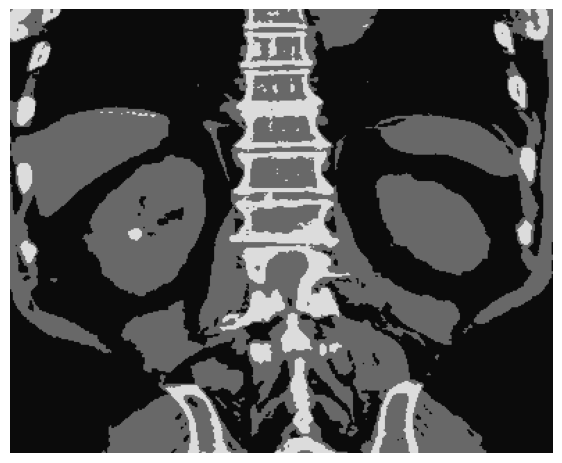

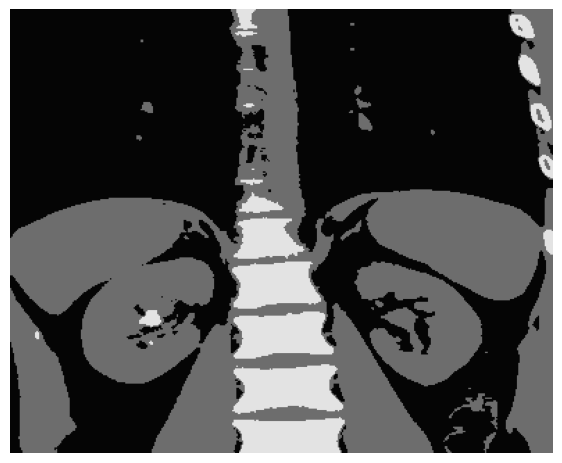

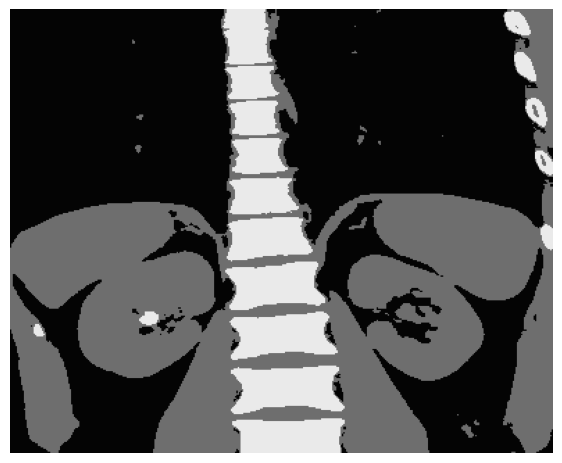

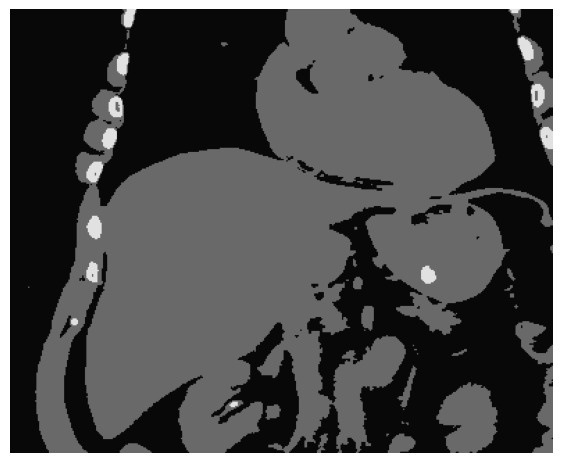

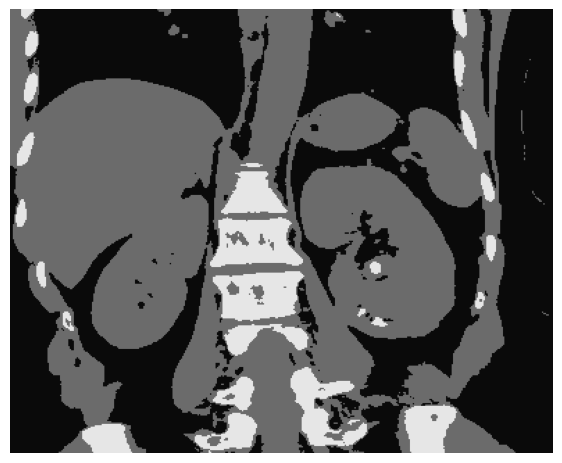

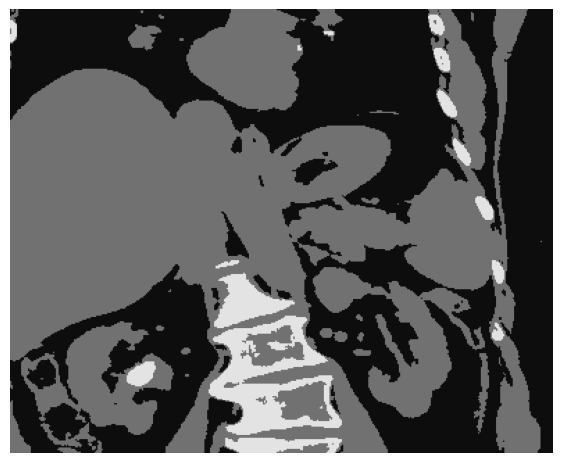

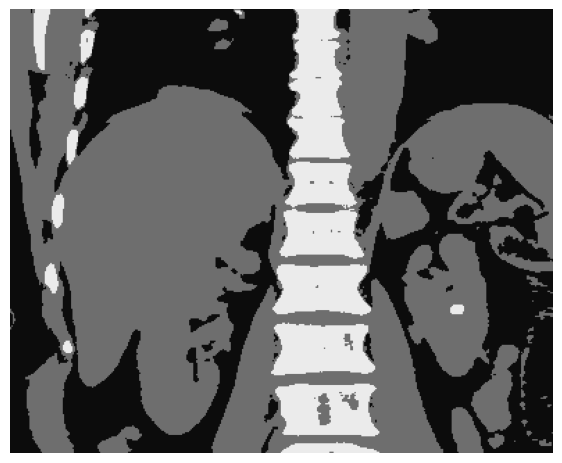

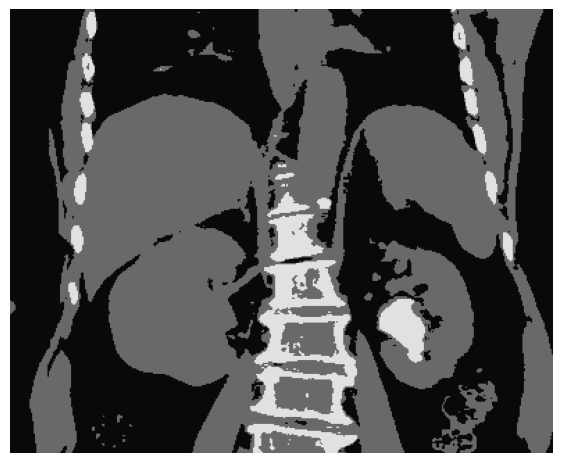

In [90]:
for i in range(0, 10):
  img=images[i]
  img_kmeans,_=kmeans(img,3,10,0.9)
  plt.figure(figsize=(7,7))
  plt.imshow(img_kmeans, cmap="gray",vmin=0, vmax=255)
  plt.axis(False)
  plt.show()

[241.1337     6.330242 115.87736 ]


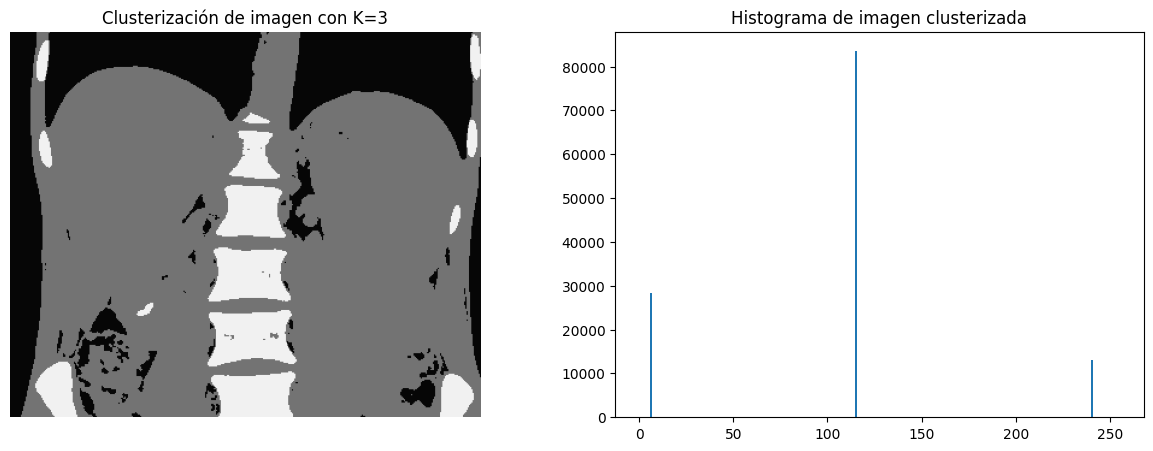

In [91]:
img=images[0]
img_cluster, centros=kmeans(img,3,10,0.9)
fig,ax = plt.subplots(1,2,figsize=(15,5))
print(centros)

ax[0].imshow(img_cluster, cmap="gray",vmin=0, vmax=255)
ax[0].set_title("Clusterización de imagen con K=3")
ax[0].axis(False)
ax[1].hist(np.ravel(img_cluster), bins=256, range=(0,255))
ax[1].set_title("Histograma de imagen clusterizada")
plt.show()

In [92]:
def binarizar(img_clust, centros):
  umb, img_bin = cv2.threshold(img_clust, max(centros)-10, 255, cv2.THRESH_BINARY)
  return umb, img_bin

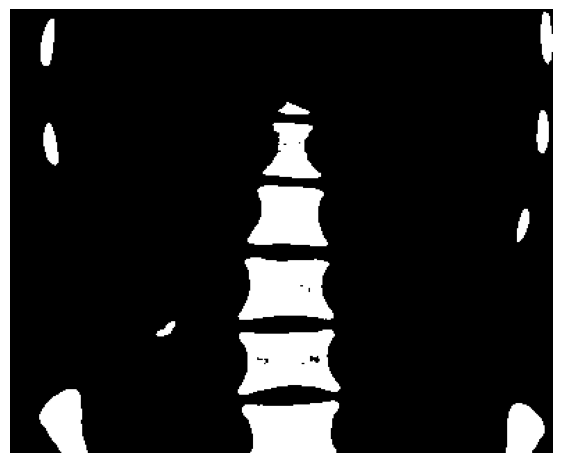

In [93]:
imgbin=binarizar(img_cluster,centros)[1]
plt.figure(figsize=(7,7))
plt.imshow(imgbin, cmap="gray",vmin=0, vmax=255)
plt.axis(False)
plt.show()

In [94]:
ret, labels = cv2.connectedComponents(imgbin)#ret es la cantidad de etiquetas y labels la matriz de la imagen etiquetada
ret


15

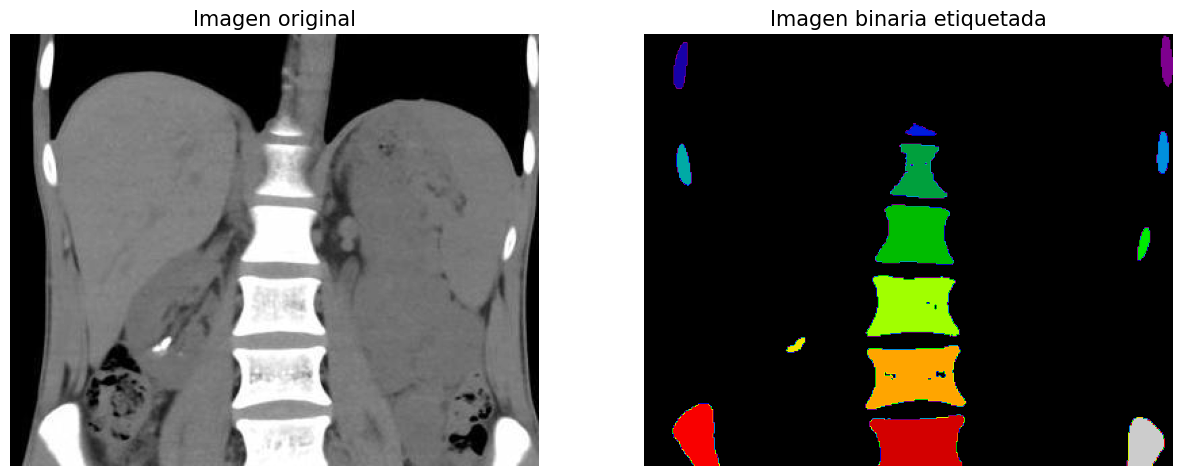

In [95]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Imagen original',fontsize=15)
plt.axis(False)
plt.subplot(122)
plt.imshow(labels, cmap='nipy_spectral')
plt.title('Imagen binaria etiquetada',fontsize=15)
plt.axis(False)
plt.show()

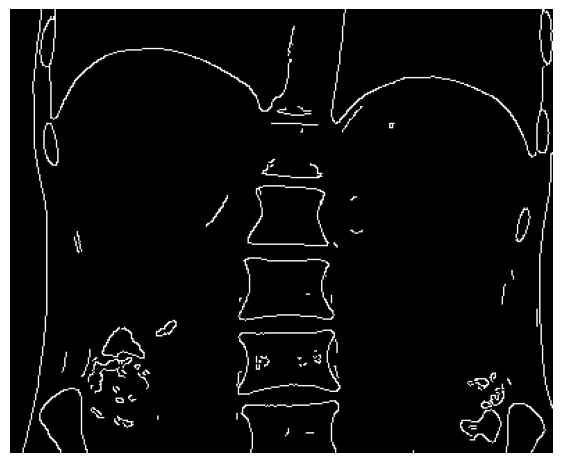

In [96]:
Canny = cv2.Canny(img, 200, 256)
plt.figure(figsize=(7,7))
plt.imshow(Canny, cmap="gray",vmin=0, vmax=255)
plt.axis(False)
plt.show()